In [1]:
import nltk 

In [8]:
import pandas as pd


In [9]:
df = pd.read_csv('clean_nus_sms.csv')
df.dropna(inplace = True)
df.head()
    

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


In [10]:
df['Message_clean'] = df['Message'].str.lower().replace('[^\w\s]','')
df.head()

,Unnamed: 0,id,Message,length,country,Date,Message_clean
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


In [11]:
import re 

In [74]:
def clean_message(text): 
    #remove URLS
    text = re.sub(r'http\S+|www\S+', '', text)
    # remove symbols 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [75]:
df['Message_clean'] = df['Message_clean'].apply(clean_message)
df.head()

,Unnamed: 0,id,Message,length,country,Date,Message_clean
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,go until jurong point crazy available only in ...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price haiz cant ...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


In [88]:
from nltk.stem import WordNetLemmatizer

In [91]:
#nomarlise the words 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df['Message_clean'] = df['Message_clean'].apply(
    lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yutianong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,id,Message,length,country,Date,Message_clean
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,go until jurong point crazy available only in ...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when let go learn pilate
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekday got special price haiz cant e...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
import numpy as np 

In [105]:
#find most frequent topics
#custom stop words 
stopwords = {'u','haha','hahaha','lol','ur', 'oh', 'lo', 'lor', 'la', 'le','ha', 'da', 'na', 'wa', 'yeah', 'hi' ,'hai','sm','hee','hey','im','ok','okay','lah', 'liao','eh', 'll','ya','tt','ah','leh'}

stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)
stop_words = list(stop_words)

#vectorize
vectorizer = CountVectorizer(stop_words = stop_words, max_df = 0.8, min_df = 3 )
X = vectorizer.fit_transform(df['Message_clean'])
#train LDA
lda= LatentDirichletAllocation(n_components =3, random_state = 42 , learning_method = 'batch')
lda.fit(X) 

doc_topics = lda.transform(X) 
df_topics = pd.DataFrame(doc_topics, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
dominant_topic = df_topics.idxmax(axis=1)

topic_counts = dominant_topic.value_counts()
def print_topics(model, feature_names, n_top_words=5):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"{idx+1}. {', '.join(top_words)}")

feature_names = vectorizer.get_feature_names_out()
print("Top Words per Topic:")
print_topics(lda, feature_names)

Top Words per Topic:
1. sorry, thanks, home, going, just
2. dont, good, know, need, free
3. got, time, dun, just, wan


In [106]:
#see where the messages are mostly comming from 
df['country'].value_counts()

country
Singapore              31817
India                   7085
United States           5680
Sri Lanka               1047
Malaysia                 767
Pakistan                 751
Unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
Barbados                   8
Spain                      5
France                     5
Name: count, dtype: int64

In [102]:
#match abbreviations to country names 
df = df.replace({'country':{'SG':'Singapore', 
                            'USA':'United States',
                            'india':'India',
                            'INDIA':'India',
                            'srilanka':'Sri Lanka',
                            'UK':'United Kingdom',
                            'BARBADOS':'Barbados',
                            'jamaica':'Jamaica',
                            'MY':'Malaysia',
                            'unknown':'Unknown'}})
df['country'].nunique()

33

In [107]:
# sentiment analysis (to see if the text are postive or negative) 
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/yutianong/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yutianong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yutianong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [108]:
from nltk.corpus import twitter_samples

In [111]:
postive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")
print(postive_tweets[0], len(postive_tweets))
print(negative_tweets[0], len(negative_tweets))

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :) 5000
hopeless for tmr :( 5000


In [113]:
# tokenised pos and neg tweets 
pos_tweets_tokens = twitter_samples.tokenized('positive_tweets.json')
neg_tweets_tokens = twitter_samples.tokenized('negative_tweets.json')

In [122]:
# clean data - remove URLS + symbols + lemmatize 
pos_tweets_clean = []
neg_tweets_clean = [] 

for tweets in pos_tweets_tokens: 
    cleaned_tweets = []
    for word in tweets: 
        word = word.lower()
        word = clean_message(word) 
        word = lemmatizer.lemmatize(word)
        if word: 
            cleaned_tweets.append(word)
    pos_tweets_clean.append(cleaned_tweets ) 

for tweets in neg_tweets_tokens: 
    cleaned_tweets = []
    for word in tweets: 
        word = word.lower()
        word = clean_message(word) 
        word = lemmatizer.lemmatize(word)
        if word: 
            cleaned_tweets.append(word)
    neg_tweets_clean.append(cleaned_tweets) 

print(pos_tweets_clean[:3]) 
print(pos_tweets_clean[:3])

[['followfriday', 'franceinte', 'pkuchly57', 'milipolparis', 'for', 'being', 'top', 'engaged', 'member', 'in', 'my', 'community', 'this', 'week'], ['lamb2ja', 'hey', 'james', 'how', 'odd', 'please', 'call', 'our', 'contact', 'centre', 'on', '02392441234', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', 'many', 'thanks'], ['despiteofficial', 'we', 'had', 'a', 'listen', 'last', 'night', 'a', 'you', 'bleed', 'is', 'an', 'amazing', 'track', 'when', 'are', 'you', 'in', 'scotland']]
[['followfriday', 'franceinte', 'pkuchly57', 'milipolparis', 'for', 'being', 'top', 'engaged', 'member', 'in', 'my', 'community', 'this', 'week'], ['lamb2ja', 'hey', 'james', 'how', 'odd', 'please', 'call', 'our', 'contact', 'centre', 'on', '02392441234', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', 'many', 'thanks'], ['despiteofficial', 'we', 'had', 'a', 'listen', 'last', 'night', 'a', 'you', 'bleed', 'is', 'an', 'amazing', 'track', 'when', 'are', 'you', 'in', 'scotland']]


In [130]:
all_tweets = pos_tweets_clean + neg_tweets_clean 
list_all_tweets =[token for sublist in all_tweets for token in sublist]
print(list_all_tweets[:5])

['followfriday', 'franceinte', 'pkuchly57', 'milipolparis', 'for']


In [132]:
all_tokens = nltk.FreqDist(list_all_tweets)
#select the 10,000 most common words to be our feature 
sentiment_features = [word for (word,freq) in all_tokens.most_common(10000)]


In [139]:
#create a feature extractor to identify if the feature is present in the message 
def extract_feature(test_sentence, sentiment_features): 
    test_tokens = set(test_sentence) 
    features = {}
    for token in sentiment_features: 
        features[token] = (token in test_tokens)
    return features 

test_sentence = 'random sentence: code, please, weekend, i'.split(" ")
extract_feature(test_sentence, sentiment_features) 

{'i': True,
 'you': False,
 'to': False,
 'the': False,
 'a': False,
 'it': False,
 'and': False,
 'my': False,
 'for': False,
 'me': False,
 'in': False,
 'is': False,
 'so': False,
 'of': False,
 'have': False,
 'im': False,
 'd': False,
 'on': False,
 'this': False,
 'but': False,
 'u': False,
 'that': False,
 'be': False,
 'thanks': False,
 'your': False,
 'love': False,
 'no': False,
 'follow': False,
 'not': False,
 'just': False,
 'like': False,
 'all': False,
 'with': False,
 'day': False,
 'we': False,
 'wa': False,
 'please': False,
 'are': False,
 'at': False,
 'get': False,
 'too': False,
 'can': False,
 'good': False,
 'dont': False,
 'do': False,
 'will': False,
 'want': False,
 'up': False,
 'now': False,
 'cant': False,
 'time': False,
 'back': False,
 'know': False,
 'one': False,
 'if': False,
 'see': False,
 'thank': False,
 'miss': False,
 'what': False,
 'out': False,
 '3': False,
 'go': False,
 'when': False,
 'much': False,
 'today': False,
 'he': False,
 'happy'

In [141]:
from sklearn.model_selection import train_test_split
from nltk import classify
from nltk import NaiveBayesClassifier

In [150]:
#split the data set - 70% train data, 30% test data 
postive_feature = [(extract_feature(tweet, sentiment_features),'pos')for tweet in pos_tweets_clean]
negative_feature =[(extract_feature(tweet, sentiment_features),'neg') for tweet in neg_tweets_clean ]
all_feature = postive_feature + negative_feature 
train_data, test_data = train_test_split(all_feature, test_size = 0.3, random_state= 42, shuffle = True) 

classifier = nltk.NaiveBayesClassifier.train(train_data) 
print(f"accuracy : {classify.accuracy(classifier,test_data) * 100} %")
print(classifier.most_informative_features(10)) 


accuracy : 77.53333333333333 %
[('follower', True), ('d', True), ('sad', True), ('arrived', True), ('justin', True), ('glad', True), ('x15', True), ('welcome', True), ('p', True), ('damn', True)]


In [151]:
df.head() 

,Unnamed: 0,id,Message,length,country,Date,Message_clean
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,go until jurong point crazy available only in ...
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when let go learn pilate
3,3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den only weekday got special price haiz cant e...
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la


In [155]:
#use model on text message to analyse (test) 
test_message =str(df['Message_clean'][1])
print(test_message)
print(classifier.classify(dict([token,True] for token in test_message)))


go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
pos


In [157]:
# use model on text message to analyse (real)
sentiments =[] 
for message in df['Message_clean']: 
    sentiments.append(str(classifier.classify(dict([token, True] for token in message)))) 

df['sentiments'] = sentiments 
df.head()

,Unnamed: 0,id,Message,length,country,Date,Message_clean,sentiments
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,neg
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,go until jurong point crazy available only in ...,pos
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when let go learn pilate,pos
3,3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den only weekday got special price haiz cant e...,pos
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,neg


In [159]:
import seaborn as sns

<Axes: xlabel='sentiments', ylabel='count'>

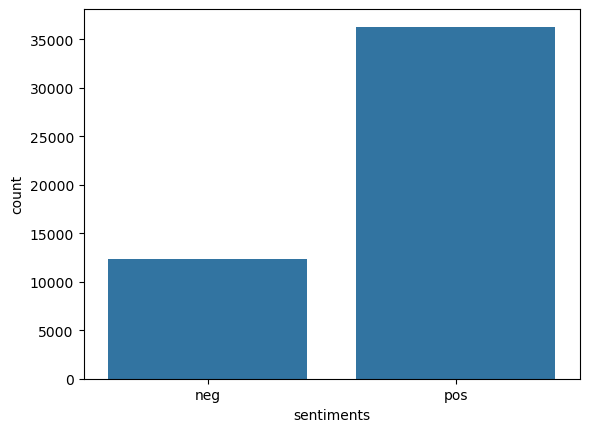

In [160]:
sns.countplot(x= "sentiments", data = df )

In [163]:
# convert the sentiments to binary value 
def convert_sentiments(sentiments): 
    if sentiments == 'pos' : 
        return 1 
    return -1
df['sentiment_score'] = df['sentiments'].apply(convert_sentiments) 
df.head()
    

,Unnamed: 0,id,Message,length,country,Date,Message_clean,sentiments,sentiment_score
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,neg,-1
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,go until jurong point crazy available only in ...,pos,1
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when let go learn pilate,pos,1
3,3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den only weekday got special price haiz cant e...,pos,1
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,neg,-1


In [167]:
# see which country has the most positive / negative texts 
df_mean_sentiment = df.groupby('country')['sentiment_score'].mean().reset_index()
df_mean_sentiment.sort_values('sentiment_score')


,country,sentiment_score
5,France,-0.200000
2,Barbados,0.000000
18,New Zealand,0.000000
29,Turkey,0.200000
13,Lebanon,0.200000
10,Italia,0.200000
7,Hungary,0.214286
0,Australia,0.333333
22,Romania,0.333333
16,Morocco,0.333333
